# Bipedal Walker (easy)
[Documentation](https://gymnasium.farama.org/environments/box2d/bipedal_walker/)  
This environment is part of the Box2D environments which contains general information about the environment.

[leaderboard](https://github.com/openai/gym/wiki/Leaderboard#bipedalwalker-v2)

## Description
This is a simple 4-joint walker robot environment. There are two versions:

- Normal, with slightly uneven terrain.
- Hardcore, with ladders, stumps, pitfalls.
ls.

To solve the normal version, you need to get 300 points in 1600 time steps. To solve the hardcore version, you need 300 points in 2000 time steps.

We have decided to used the DDPG algorithme with the TD3 variant, we used 5 critics and D2RL architecture model to help them to learn. We also use normalization on states and rewards.

In [1]:
# import standard libraries
import os
import base64
import random
import time
import copy
from collections import namedtuple, deque

# import third-party libraries
import gymnasium as gym
import numpy as np
import pandas as pd
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from lion_pytorch import Lion

import imageio
import cv2
from IPython.display import clear_output, display, HTML
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.figure import Figure
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

## Hardware infos

In [2]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce GTX 1070 (UUID: GPU-19cef1c2-e216-e824-c98e-660394f8a4bb)


In [3]:
print(f"torch.version.cuda=[{torch.version.cuda}]")
print(f"torch.cuda.is_available({torch.cuda.is_available()})")     

torch.version.cuda=[11.7]
torch.cuda.is_available(True)


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Create directories

In [5]:
os.makedirs('img/bipedal_walker_easy', exist_ok=True)
os.makedirs('saves/bipedal_walker_easy', exist_ok=True)
print('./img/bipedal_walker_easy :')
!ls -al "img/bipedal_walker_easy"
print('./saves/bipedal_walker_easy :')
!ls -al "saves/bipedal_walker_easy"

./img/bipedal_walker_easy :
total 4
drwxr-xr-x 1 thiba 197609 0 Jun 25 18:31 .
drwxr-xr-x 1 thiba 197609 0 Jun 25 18:31 ..
./saves/bipedal_walker_easy :
total 5313
drwxr-xr-x 1 thiba 197609      0 Jun 25 19:22 .
drwxr-xr-x 1 thiba 197609      0 Jun 25 18:31 ..
drwxr-xr-x 1 thiba 197609      0 Jun 25 18:53 .ipynb_checkpoints
-rw-r--r-- 1 thiba 197609 896447 Jun 25 22:24 bipedal_walker_easy_actor_model.pth
-rw-r--r-- 1 thiba 197609 901331 Jun 25 22:24 bipedal_walker_easy_critic0_model.pth
-rw-r--r-- 1 thiba 197609 901331 Jun 25 22:24 bipedal_walker_easy_critic1_model.pth
-rw-r--r-- 1 thiba 197609 901331 Jun 25 22:24 bipedal_walker_easy_critic2_model.pth
-rw-r--r-- 1 thiba 197609 901331 Jun 25 22:24 bipedal_walker_easy_critic3_model.pth
-rw-r--r-- 1 thiba 197609 901331 Jun 25 22:24 bipedal_walker_easy_critic4_model.pth
-rw-r--r-- 1 thiba 197609   1031 Jun 25 22:24 bipedal_walker_easy_normalizer.pkl
-rw-r--r-- 1 thiba 197609    239 Jun 25 22:24 bipedal_walker_easy_reward_normalizer.pkl


## Constants
### Hyperparameters

In [6]:
BUFFER_SIZE = 1_000_000
BATCH_SIZE = 128
GAMMA = 0.98
TAU = 0.02
LR_ACTOR = 0.0001
LR_CRITIC = 0.0003
WEIGHT_DECAY = 0.00
POLICY_NOISE = 0.2
NOISE_CLIP = 0.5
POLICY_FREQ = 2
START_LEARNING = 10000 # steps in the beginning to let the agent explore
N_TOTAL_EPISODES = 3000
N_CRITICS = 5
OPTIM = "ADAM" # "LION"

### Paths

In [7]:
PATH = "./saves/bipedal_walker_easy/bipedal_walker_easy"
PATH_IMG = "./img/bipedal_walker_easy/bipedal_walker_easy"

## Utils

In [8]:
def print_infos(ep_len_mean, ep_rew_mean, ep_len, ep_rew, min_rew, ep_min_rew, episodes, fps, time_elapsed, total_timesteps, actor_loss, critic_loss_arr, learning_rate, n_updates):
    print(f"- rollout/")
    print(f"    - ep_len_mean     : {ep_len_mean}")
    print(f"    - ep_rew_mean     : {ep_rew_mean}")
    print(f"    - ep_len          : {ep_len}")
    print(f"    - ep_rew          : {ep_rew}")
    print(f"    - max_rew         : {min_rew}")
    print(f"    - ind_max_rew     : {ep_min_rew}")
    print(f"")
    print(f"- time/")
    print(f"    - episodes        : {episodes}")
    print(f"    - fps             : {fps}")
    print(f"    - time_elapsed    : {time_elapsed}")
    print(f"    - total_timesteps : {total_timesteps}")
    print(f"")
    print(f"- train/")
    print(f"    - actor_loss      : {actor_loss}")
    for i, c in enumerate(critic_loss_arr):
        print(f"    - critic_loss{i+1}    : {c}")
    print(f"    - learning_rate   : {learning_rate}")
    print(f"    - n_updates       : {n_updates}")

In [9]:
def save_gif(img_list, path):
    # Convert the list of frames to a numpy array
    resized_img_array = []
    for img in img_list:
        img_pil = Image.fromarray(img)
        # Make sure width and height are divisible by 16
        img_resized_pil = img_pil.resize((608, 400))
        img_resized = np.array(img_resized_pil)
        resized_img_array.append(img_resized)
    
    # Create gif video
    fps = 20
    imageio.mimsave(path, resized_img_array, 'GIF', duration=int(1000 * 1/fps), loop=0)

In [10]:
def plot_history(reward_history, rolling_window=20, x_label = 'Episode', y_label = 'Total Points', lower_limit=None, upper_limit=None, plot_rw=True, plot_rm=True):
    """
    Function to plot reward history and its rolling mean with some optional arguments.

    Args:
        reward_history (list): A list of rewards for each episode.
        rolling_window (int): The number of episodes for computing the rolling mean.
        lower_limit (int): Starting episode index for plotting.
        upper_limit (int): Ending episode index for plotting.
        plot_rw (bool): A flag for plotting raw reward history.
        plot_rm (bool): A flag for plotting rolling mean reward history.

    Returns:
        None
    """
    
    # If lower_limit and upper_limit are not provided, use the whole reward_history
    if lower_limit is None or upper_limit is None:
        rh = reward_history
        xs = [x for x in range(len(reward_history))]
    else:
        rh = reward_history[lower_limit:upper_limit]
        xs = [x for x in range(lower_limit,upper_limit)]
   
    # Create a DataFrame and calculate the rolling mean
    df = pd.DataFrame(rh)
    rollingMean = df.rolling(rolling_window).mean()

    # Plot the results
    plt.figure(figsize=(10,7), facecolor='white')
    
    if plot_rw:
        plt.plot(xs, rh, linewidth=1, color='cyan')
    if plot_rm:
        plt.plot(xs, rollingMean, linewidth=2, color='magenta')

    text_color = 'black'
        
    ax = plt.gca()
    ax.set_facecolor('black')
    plt.grid()

    plt.xlabel(x_label, color=text_color, fontsize=30)
    plt.ylabel(y_label, color=text_color, fontsize=30)
    yNumFmt = mticker.StrMethodFormatter('{x:,}')
    ax.yaxis.set_major_formatter(yNumFmt)
    ax.tick_params(axis='x', colors=text_color)
    ax.tick_params(axis='y', colors=text_color)
    plt.show()

In [11]:
def print_hyperparameters():
    print("----------------------------------")
    print(f"| {BUFFER_SIZE=} \t\t |")
    print(f"| {BATCH_SIZE=} \t\t |")
    print(f"| {GAMMA=} \t\t\t |")
    print(f"| {TAU=} \t\t\t |")
    print(f"| {LR_ACTOR=} \t\t |")
    print(f"| {LR_CRITIC=} \t\t |")
    print(f"| {WEIGHT_DECAY=} \t\t |")
    print(f"| {POLICY_NOISE=} \t\t |")
    print(f"| {NOISE_CLIP=} \t\t |")
    print(f"| {POLICY_FREQ=} \t\t |")
    print(f"| {START_LEARNING=} \t\t |")
    print(f"| {N_TOTAL_EPISODES=} \t |")
    print(f"| {N_CRITICS=} \t\t\t |")
    print(f"| {OPTIM=} \t\t\t |")
    print("----------------------------------")

## Experience Replay

In [12]:
Experience = namedtuple('Experience', field_names=['state', 'action', 'reward', 'next_state', 'done'])

In [13]:
class ReplayBuffer:
    def __init__(self, buffer_size, batch_size):
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size

    def add(self, state, action, reward, next_state, done):
        e = Experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

## Normalizer
### States normalizer

In [14]:
class Normalizer():
    def __init__(self, size):
        self.n = np.zeros(size)
        self.mean = np.zeros(size)
        self.M2 = np.zeros(size)
        self.var = np.full(size, 1e-2)

    def observe(self, x):
        self.n += 1.0
        delta = x - self.mean
        self.mean += delta / self.n
        delta2 = x - self.mean
        self.M2 += delta * delta2
        less_than_two = self.n < 2
        self.var = np.where(less_than_two, np.full(self.var.shape, 1e-2), self.M2 / (self.n - 1))
        self.var = np.maximum(self.var, 1e-2)  # Clip the variance to a minimum value

    def normalize(self, inputs):
        obs_std = np.sqrt(self.var)
        return (inputs - self.mean) / obs_std

    def observe2d(self, x):
        x = np.atleast_2d(x)  # Make sure x is at least 2-D
        batch_size, _ = x.shape
        self.n += batch_size
        for instance in x:
            delta = instance - self.mean
            self.mean += delta / self.n
            delta2 = instance - self.mean
            self.M2 += delta * delta2
        less_than_two = self.n < 2
        self.var = np.where(less_than_two, np.full(self.var.shape, 1e-2), self.M2 / (self.n - 1))
        self.var = np.maximum(self.var, 1e-2)  # Clip the variance to a minimum value

    def save(self):
        with open(f"{PATH}_normalizer.pkl", 'wb') as f:
            pickle.dump(self.__dict__, f)

    def load(self):
        with open(f"{PATH}_normalizer.pkl", 'rb') as f:
            tmp_dict = pickle.load(f)
        self.__dict__.update(tmp_dict)


### Reward normalizer

In [15]:
class RewardNormalizer():
    def __init__(self, dim=1):
        self.n = 0
        self.dim = dim
        self.mean = np.zeros(self.dim)
        self.M2 = np.zeros(self.dim)
        self.var = np.full(self.dim, 1e-2)

    def observe(self, x):
        self.n += 1
        delta = x - self.mean
        self.mean += delta / self.n
        delta2 = x - self.mean
        self.M2 += delta * delta2
        if self.n < 2:
            self.var = np.full(self.dim, 1e-2)
        else:
            self.var = self.M2 / (self.n - 1)
        self.var = np.maximum(self.var, 1e-2)  # Clip the variance to a minimum value

    def normalize(self, reward):
        reward_std = np.sqrt(self.var)
        return (reward - self.mean) / reward_std

    def observe2d(self, x):
        x = np.atleast_2d(x)  # Make sure x is at least 2-D
        batch_size, dim = x.shape
        assert dim == self.dim, "Input dimensions do not match initialized dimensions"
        self.n += batch_size
        for instance in x:
            delta = instance - self.mean
            self.mean += delta / self.n
            delta2 = instance - self.mean
            self.M2 += delta * delta2
        if self.n < 2:
            self.var = np.full(self.dim, 1e-2)
        else:
            self.var = self.M2 / (self.n - 1)
        self.var = np.maximum(self.var, 1e-2)  # Clip the variance to a minimum value

    def save(self):
        with open(f"{PATH}_reward_normalizer.pkl", 'wb') as f:
            pickle.dump((self.n, self.mean, self.M2, self.var), f)

    def load(self):
        with open(f"{PATH}_reward_normalizer.pkl", 'rb') as f:
            self.n, self.mean, self.M2, self.var = pickle.load(f)

## Network
### Actor Network

In [16]:
class Actor(nn.Module):
    def __init__(self, state_size, action_size, seed, fc1_units=512, fc2_units=256, fc3_units=256):
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units+state_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units+state_size, fc3_units)
        self.fc4 = nn.Linear(fc3_units+state_size, action_size)

    def forward(self, state):
        x1 = F.relu(self.fc1(state))
        x2 = F.relu(self.fc2(torch.cat([x1, state], dim=1)))
        x3 = F.relu(self.fc3(torch.cat([x2, state], dim=1)))
        return torch.tanh(self.fc4(torch.cat([x3, state], dim=1)))

### Critic Network

In [17]:
class Critic(nn.Module):
    def __init__(self, state_size, action_size, seed, fcs1_units=512, fc2_units=256, fc3_units=256):
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+state_size+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units+state_size+action_size, fc3_units)
        self.fc4 = nn.Linear(fc3_units+state_size+action_size, 1)

    def forward(self, state, action):
        x1 = F.relu(self.fcs1(state))
        x2 = F.relu(self.fc2(torch.cat((x1, state, action), dim=1)))
        x3 = F.relu(self.fc3(torch.cat((x2, state, action), dim=1)))
        return self.fc4(torch.cat((x3, state, action), dim=1))

## DDPG Agent

In [18]:
class Agent:
    def __init__(self, state_size, action_size, reward_normalizer, n_critics = 3, random_seed = 0):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)

        # actor optimizers
        # adam_opti_actor = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)
        # lion_opti_actor = Lion(self.actor_local.parameters(), lr=LR_ACTOR)
        optimizer = Lion if OPTIM == "LION" else optim.Adam
        # Actor Network 
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optimizer(self.actor_local.parameters(), lr=LR_ACTOR)
        self.actor_loss_history = []
        self.actor_loss_history_mean = []

        # Critic optimizers
        # adam_opti_critics = optim.Adam(self.critic_local[idx].parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)
        # lion_opti_actor = Lion(self.critic_local[idx].parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)
        # Critic Network (w/ Target Network)
        self.n_critics = n_critics
        self.critic_local = [Critic(state_size, action_size, random_seed).to(device) for _ in range(self.n_critics)]
        self.critic_target = [Critic(state_size, action_size, random_seed).to(device) for _ in range(self.n_critics)]
        self.critic_optimizer = [optimizer(self.critic_local[idx].parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY) for idx in range(self.n_critics)]
        self.critic_loss_history = [[] for _ in range(self.n_critics)]
        self.critic_loss_history_mean = [[] for _ in range(self.n_critics)]

        # Replay memory
        self.memory = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE)
        
        # Reward Normalizer
        self.reward_normalizer = reward_normalizer
        
        self.n_updates = 0

    def calculate_loss_history(self):
        # removing nan
        x = np.array([self.actor_loss_history])
        x = x[~np.isnan(x)]
        # calculate mean
        if len(x) > 0:
            self.actor_loss_history_mean.append(np.mean(x))
        # re initialize history
        self.actor_loss_history = []
        # free memory
        del x

        for idx in range(self.n_critics):
            # removing nan
            x = np.array([self.critic_loss_history[idx]])
            x = x[~np.isnan(x)]
            # calculate mean
            if len(x) > 0:
                self.critic_loss_history_mean[idx].append(np.mean(x))
            # re initialize history
            self.critic_loss_history[idx] = []
            # free memory
            del x
            
    def step(self, state, action, reward, next_state, done, timestep):
        self.memory.add(state, action, reward, next_state, done)

        if len(self.memory) > BATCH_SIZE and timestep % POLICY_FREQ == 0:
            experiences = self.memory.sample()
            states, actions, rewards, next_states, dones = experiences
            # switch to numpy
            states = states.cpu().numpy()
            next_states = next_states.cpu().numpy()
            rewards = rewards.cpu().numpy()
            # Normalize states
            normalizer.observe2d(states)
            states = normalizer.normalize(states)
            # Normalize next_states
            normalizer.observe2d(next_states)
            next_states = normalizer.normalize(next_states)
            # Normalize rewards
            self.reward_normalizer.observe2d(rewards)
            rewards = self.reward_normalizer.normalize(rewards)
            # switch to tensor
            states = torch.from_numpy(states).float().to(device)
            next_states = torch.from_numpy(next_states).float().to(device)
            rewards = torch.from_numpy(rewards).float().to(device)
            self.learn((states, actions, rewards, next_states, dones), GAMMA)

    def act(self, state, add_noise=True):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            noise = np.random.normal(0, POLICY_NOISE, size=self.action_size)
            noise = np.clip(noise, -NOISE_CLIP, NOISE_CLIP)
            action += noise
        return np.clip(action, -1, 1)

    def save_model(self):
        torch.save(self.actor_local.state_dict(), f"{PATH}_actor_model.pth")
        for idx, critic_local in enumerate(self.critic_local):
            torch.save(critic_local.state_dict(), f"{PATH}_critic{idx}_model.pth")

    def load_model(self):
        self.actor_local.load_state_dict(torch.load(f"{PATH}_actor_model.pth"))
        for idx in range(self.n_critics):
            self.critic_local[idx].load_state_dict(torch.load(f"{PATH}_critic{idx}_model.pth"))
        
    def get_lr(self):
        for param_group in self.actor_optimizer.param_groups:
            return param_group['lr']

    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        noise = torch.normal(torch.zeros(actions.size()), POLICY_NOISE).to(device)
        noise = torch.clamp(noise, -NOISE_CLIP, NOISE_CLIP)
        actions_next = self.actor_target(next_states) + noise
        actions_next = torch.clamp(actions_next, -1, 1)

        Q_targets_next_arr = [self.critic_target[idx](next_states, actions_next) for idx in range(self.n_critics)]

        Q_targets_next = Q_targets_next_arr[0]
        for idx in range(1, self.n_critics):
            Q_targets_next = torch.min(Q_targets_next, Q_targets_next_arr[idx])
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Compute all critic loss
        for idx in range(self.n_critics):
            # Zero gradients
            self.critic_optimizer[idx].zero_grad()
            # Compute critic loss
            Q_expected = self.critic_local[idx](states, actions)
            critic_loss = F.mse_loss(Q_expected, Q_targets.detach()) # detach Q_targets here to avoid the "the graph are freed" error
            # Save the critic loss
            self.critic_loss_history[idx].append(critic_loss.item())
            # Backward pass
            critic_loss.backward()
            # Update weights
            self.critic_optimizer[idx].step()

        # ---------------------------- update actor ---------------------------- #
        # Zero gradients
        self.actor_optimizer.zero_grad()
        # Compute critic loss
        actions_pred = self.actor_local(states)
        # Compute the average of the critics
        critic_values = [self.critic_local[idx](states, actions_pred) for idx in range(self.n_critics)]
        critic_value = sum(critic_values) / float(self.n_critics)
        actor_loss = -critic_value.mean()
        # Save the loss
        self.actor_loss_history.append(actor_loss.item())
        # Backward pass
        actor_loss.backward()
        # Update weights
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        for idx in range(self.n_critics):
            self.soft_update(self.critic_local[idx], self.critic_target[idx], TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)
        
        self.n_updates += 1
        
    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

    def summary(self):
        print(self.actor_local)
        print(self.critic_local)

## Train
### Classic ddpg

In [19]:
def ddpg(env, agent, normalizer, reward_normalizer, n_episodes=1000, max_t=1000):
    scores_deque = deque(maxlen=100)
    timesteps_deque = deque(maxlen=100)
    scores = []
    start_time_elapsed = time.time()
    total_timesteps = 0
    min_rew = -1500 
    ep_min_rew = 0
    for i_episode in range(1, n_episodes+1):
        # function to override printlines from previous loop iteration 
        clear_output(wait=True)
        state, _ = env.reset()
        # State normalization
        normalizer.observe(state)
        normalized_state = normalizer.normalize(state)
        score = 0
        timestep = 0
        done = False
        while not done:
            if total_timesteps >= START_LEARNING:
                action = agent.act(normalized_state).squeeze(0)
            else:
                action = env.action_space.sample()  # Sample random action
            next_state, reward, terminated, truncated, _ = env.step(action)
            next_state = torch.from_numpy(next_state.T).float().squeeze(0).numpy()
            
            # State normalization
            normalizer.observe(next_state)
            normalized_next_state = normalizer.normalize(next_state)
        
            done = terminated or truncated
            agent.step(state, action, reward, next_state, done, total_timesteps)
            state = next_state
            normalized_state = normalized_next_state
            score += reward
            timestep += 1
            total_timesteps += 1
        scores_deque.append(score)
        timesteps_deque.append(timestep)
        scores.append(score)
        agent.calculate_loss_history()

        time_elapsed = time.time() - start_time_elapsed
        if min_rew <= score:
            min_rew = score
            ep_min_rew = i_episode
            agent.save_model()
            normalizer.save()
            reward_normalizer.save()
        print_infos(
            int(np.mean(timesteps_deque)),
            np.mean(scores_deque),
            timestep,
            score,
            min_rew,
            ep_min_rew, 
            i_episode,
            int(total_timesteps / time_elapsed),
            int(time_elapsed),
            total_timesteps,
            np.mean(agent.actor_loss_history_mean[-100:]),
            [np.mean(critic_loss_history) for critic_loss_history in agent.critic_loss_history_mean[-100:]],
            agent.get_lr(),
            agent.n_updates
        )

        if np.mean(scores_deque) >= 300:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            agent.save_model()
            normalizer.save()
            reward_normalizer.save()
            break
    return scores

### create environment

#### Hyperparameters

In [20]:
print_hyperparameters()

----------------------------------
| BUFFER_SIZE=1000000 		 |
| BATCH_SIZE=128 		 |
| GAMMA=0.98 			 |
| TAU=0.02 			 |
| LR_ACTOR=0.0001 		 |
| LR_CRITIC=0.0003 		 |
| WEIGHT_DECAY=0.0 		 |
| POLICY_NOISE=0.2 		 |
| NOISE_CLIP=0.5 		 |
| POLICY_FREQ=2 		 |
| START_LEARNING=10000 		 |
| N_TOTAL_EPISODES=3000 	 |
| N_CRITICS=5 			 |
| OPTIM='ADAM' 			 |
----------------------------------


#### Environment

In [21]:
env = gym.make("BipedalWalker-v3", hardcore=False)
state_size = env.observation_space.shape[0]
action_size = env.action_space.shape[0]

#### Normalizers

In [22]:
normalizer = Normalizer(state_size)
reward_normalizer = RewardNormalizer()

#### Networks

In [23]:
agent = Agent(state_size, action_size, reward_normalizer, N_CRITICS, random_seed=0)
agent.summary()

Actor(
  (fc1): Linear(in_features=24, out_features=512, bias=True)
  (fc2): Linear(in_features=536, out_features=256, bias=True)
  (fc3): Linear(in_features=280, out_features=256, bias=True)
  (fc4): Linear(in_features=280, out_features=4, bias=True)
)
[Critic(
  (fcs1): Linear(in_features=24, out_features=512, bias=True)
  (fc2): Linear(in_features=540, out_features=256, bias=True)
  (fc3): Linear(in_features=284, out_features=256, bias=True)
  (fc4): Linear(in_features=284, out_features=1, bias=True)
), Critic(
  (fcs1): Linear(in_features=24, out_features=512, bias=True)
  (fc2): Linear(in_features=540, out_features=256, bias=True)
  (fc3): Linear(in_features=284, out_features=256, bias=True)
  (fc4): Linear(in_features=284, out_features=1, bias=True)
), Critic(
  (fcs1): Linear(in_features=24, out_features=512, bias=True)
  (fc2): Linear(in_features=540, out_features=256, bias=True)
  (fc3): Linear(in_features=284, out_features=256, bias=True)
  (fc4): Linear(in_features=284, out_

#### Run the training

In [24]:
scores = ddpg(env, agent, normalizer, reward_normalizer, N_TOTAL_EPISODES)
env.close()

- rollout/
    - ep_len_mean     : 600
    - ep_rew_mean     : 243.87851672505266
    - ep_len          : 315
    - ep_rew          : 23.564043374569138
    - max_rew         : 312.8545720264134
    - ind_max_rew     : 2911

- time/
    - episodes        : 3000
    - fps             : 60
    - time_elapsed    : 30057
    - total_timesteps : 1807784

- train/
    - actor_loss      : -4.1319827526149275
    - critic_loss1    : 0.06807691722879604
    - critic_loss2    : 0.06807691722879604
    - critic_loss3    : 0.06807691722879604
    - critic_loss4    : 0.06807691722879604
    - critic_loss5    : 0.06807691722879604
    - learning_rate   : 0.0001
    - n_updates       : 903828


### Plot rewards

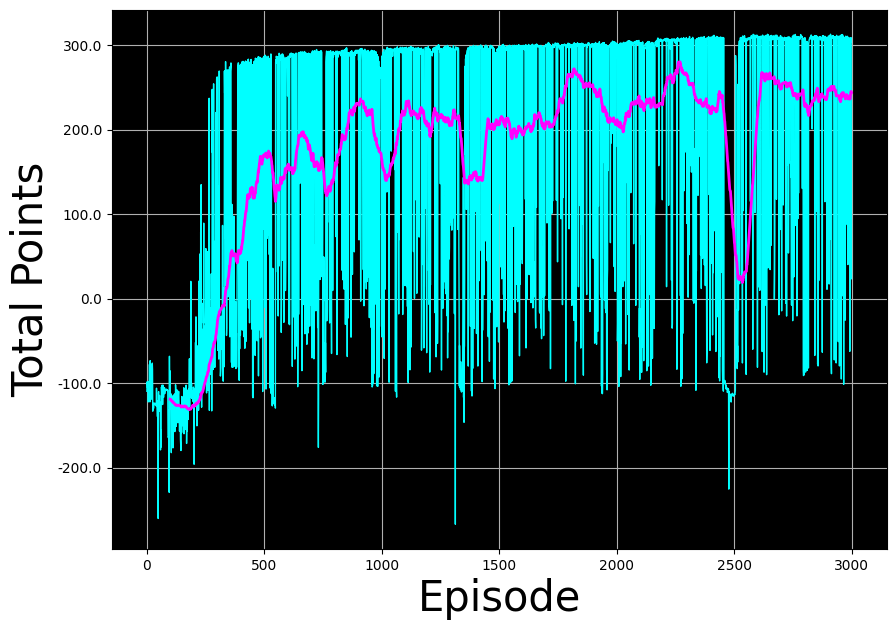

In [25]:
# Plot the point history
plot_history(scores, 100)

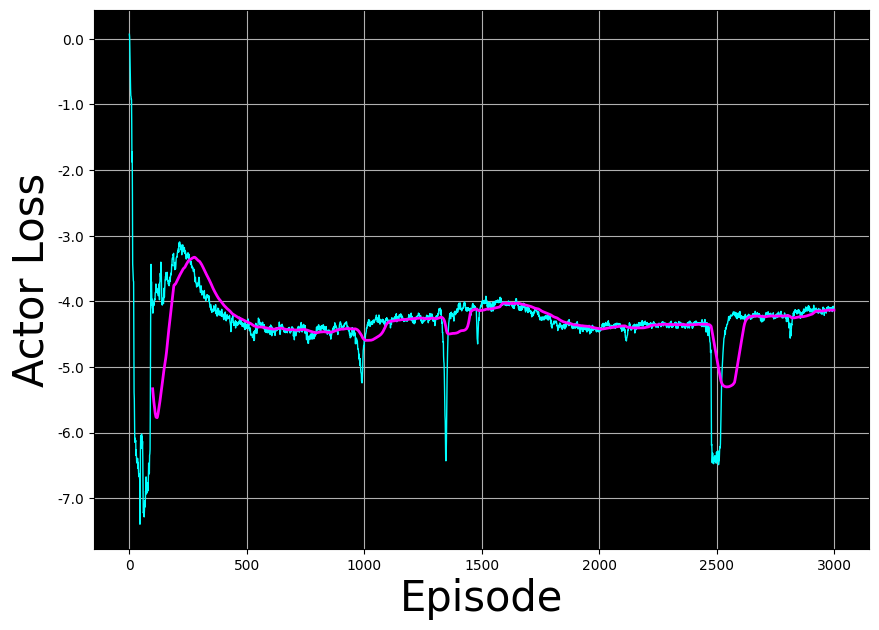

In [26]:
# Plot the point Actor loss history
plot_history(agent.actor_loss_history_mean, 100, y_label="Actor Loss")

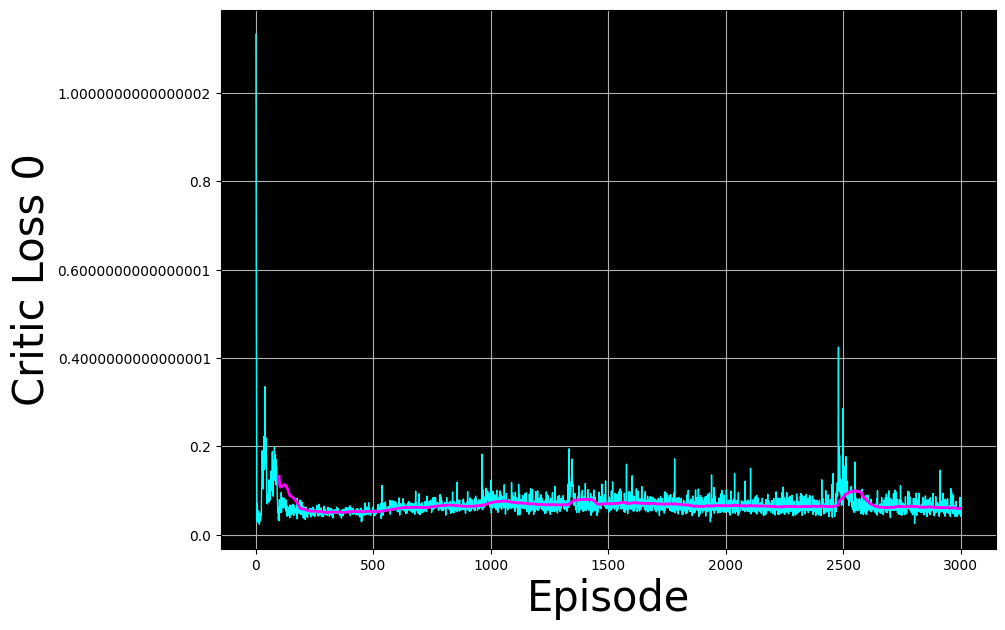

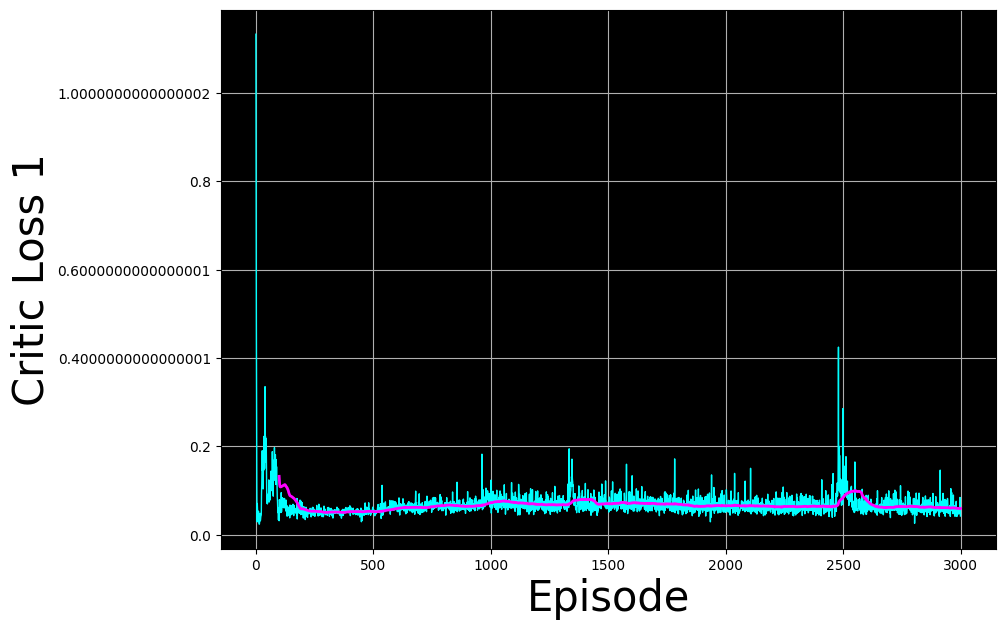

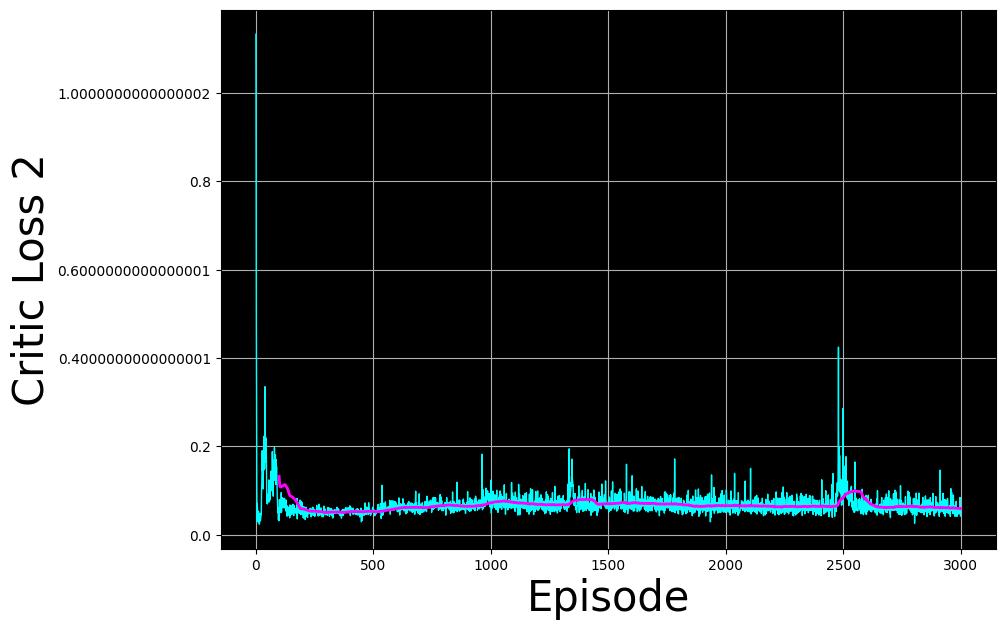

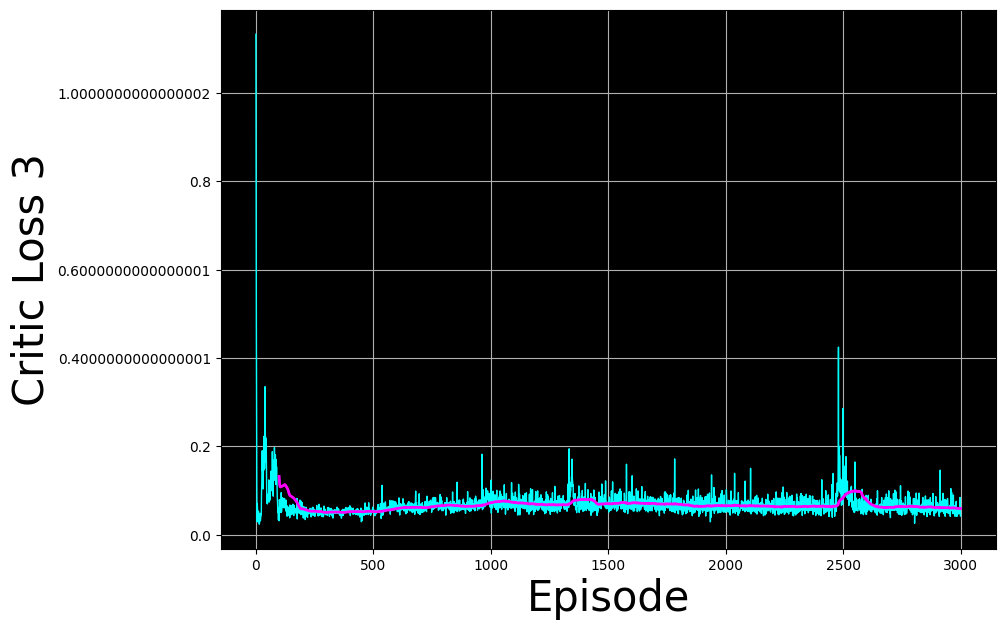

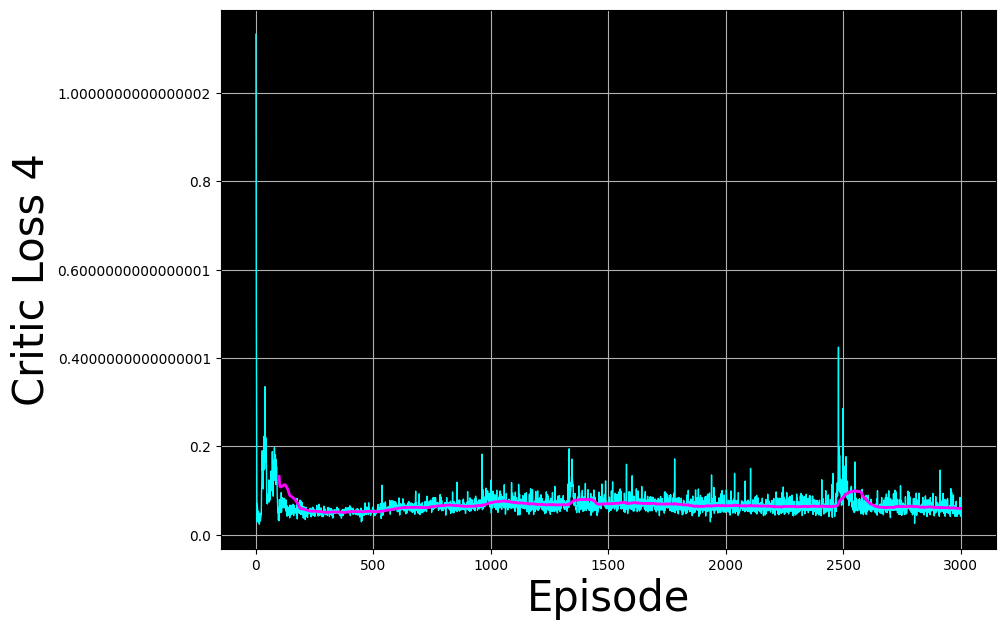

In [27]:
for idx in range(agent.n_critics):
    plot_history(agent.critic_loss_history_mean[idx], 100, y_label=f"Critic Loss {idx}")

## Visualizing
### create environment

In [28]:
env = gym.make("BipedalWalker-v3", hardcore=False, render_mode="rgb_array")
state_size = env.observation_space.shape[0]
action_size = env.action_space.shape[0]
new_normalizer = Normalizer(state_size)
new_normalizer.load()  # Load the saved statistics
new_reward_normalizer = RewardNormalizer()
new_reward_normalizer.load()
agent2 = Agent(state_size, action_size, new_reward_normalizer, random_seed=0)
agent2.load_model()

In [29]:
screen_list = []
scores = []
best_score = -1500
for i in range(10):
    state, _ = env.reset()
    #Select an action
    normalized_state = normalizer.normalize(state)
    done = False
    timestep = 0
    episode_reward = 0
    e_screen_list = []
    while not done:
        action = agent2.act(normalized_state, False).squeeze(0)
    
        # Printing env render (rgb_array)
        screen = env.render()
        # Add title to the screen
        screen = cv2.putText(
            np.array(screen),
            f"Iteration=[{i}] Timestep=[{timestep +1}]",
            (25, 25),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            (0, 0, 0),
            1,
            cv2.LINE_AA
        )
        e_screen_list.append(screen)
        
        next_state, reward, terminated, truncated, _ = env.step(action)
        next_state = torch.from_numpy(next_state.T).float().squeeze(0).numpy()
        done = terminated or truncated
    
        #Select an action
        normalized_next_state = normalizer.normalize(next_state)
        state = next_state
        normalized_state = normalized_next_state
        episode_reward += reward
    
        timestep += 1

    if best_score <= episode_reward:
        best_score = episode_reward
        screen_list.append(e_screen_list)
    
    scores.append(episode_reward)

### Scores of evaluation

In [30]:
print(f"Best score: {max(scores)}")
print(f"AVG score: {np.mean(scores)}")

Best score: 310.2387916037623
AVG score: 309.3380036335468


### Selection of the 5 best iterations

In [31]:
n = 5

In [32]:
best_screen_list = screen_list[-n:]
print(f"Number of iter : {len(best_screen_list)}")

Number of iter : 1


In [33]:
selected_screens_list = np.empty((0, 400, 600, 3))
for screen_ep in best_screen_list:
    selected_screens_list = np.concatenate((selected_screens_list, np.array(screen_ep)), axis=0)

selected_screens_list = selected_screens_list.astype(np.uint8)
print(selected_screens_list.shape)

(672, 400, 600, 3)


### Save gif

In [34]:
path = f"{PATH_IMG}.gif"
save_gif(list(selected_screens_list), path)

### Embed the video


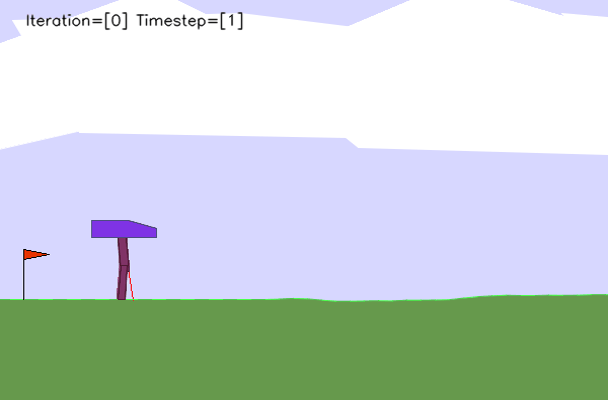

In [35]:
video = open(path, 'rb').read()
b64_video = base64.b64encode(video)
video_tag = '<img src="data:image/gif;base64,{0}">'.format(b64_video.decode())

display(HTML(video_tag))

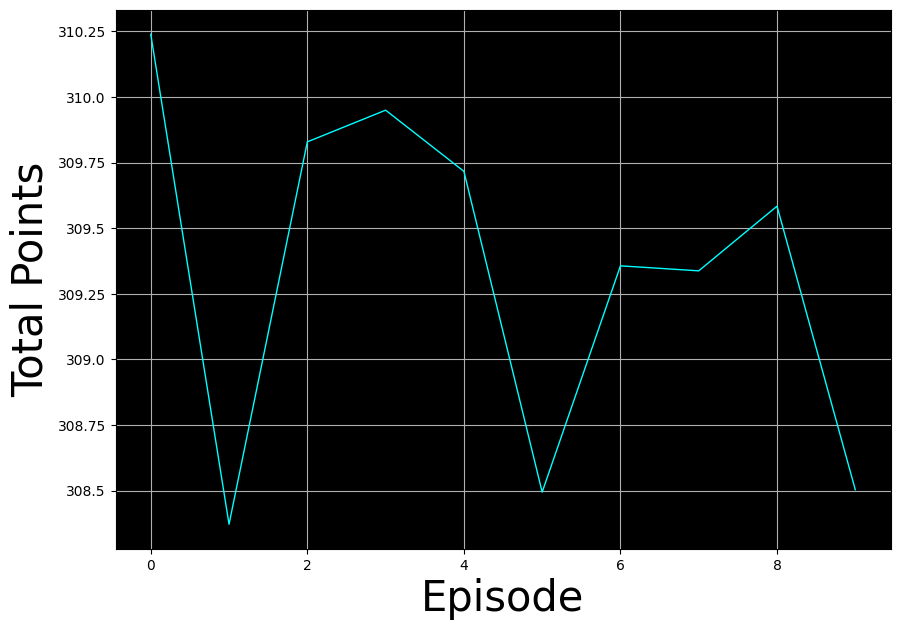

In [36]:
# Plot the point scores evaluation
plot_history(scores)